# EDA - A Quick Look at Image Matching Challenge Dataset

## Introduction

In this notebook, we explore the dataset provided for the Image Matching Challenge 2023. The goal of this competition is to generate 3D reconstructions from a set of images and accurately estimate the camera poses (rotation and translation) for each image. In this initial exploration, we perform an Exploratory Data Analysis (EDA) to better understand the dataset and its structure before diving into the development of machine learning models.

## The Plan
Our plan for this EDA consists of the following steps:

1. Load and inspect the dataset
2. Analyze the distribution of scenes and datasets
3. Visualize some sample images
4. Explore the 3D reconstructions
5. Analyze the distribution of rotation and translation values
6. Visualize rotation and translation as quaternions
7. Calculate relative pose errors
8. Plot the distribution of pose errors

The first thing I want to do is to download read_write_model.py to do some 3D exploration.

In [1]:
!wget https://raw.githubusercontent.com/colmap/colmap/dev/scripts/python/read_write_model.py

--2023-05-02 08:24:36--  https://raw.githubusercontent.com/colmap/colmap/dev/scripts/python/read_write_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21497 (21K) [text/plain]
Saving to: ‘read_write_model.py’

read_write_model.py 100%[===================>]  20.99K  --.-KB/s    in 0s      

2023-05-02 08:24:36 (50.6 MB/s) - ‘read_write_model.py’ saved [21497/21497]



In [2]:
#Import the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import pycolmap
import read_write_model

## Load the Dataset

We start by loading the training labels CSV file, which contains information about the images, their corresponding datasets and scenes, and the ground truth camera poses (rotation and translation).

In [3]:
# Load the data
root_dir = '/kaggle/input/image-matching-challenge-2023'
train_labels_file = os.path.join(root_dir, 'train/train_labels.csv')
train_labels = pd.read_csv(train_labels_file)

train_labels.head()

,dataset,scene,image_path,rotation_matrix,translation_vector
0,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,0.961211667939937;0.012901284585988954;0.27550...,-15.272578207792487;-0.6299638684926413;21.960...
1,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,0.9983992256415107;0.03067020011152836;0.04752...,-10.86744827847772;5.142649233329267;22.080480...
2,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,-0.00887553412819142;-0.176226804404349;-0.984...,21.65171058540772;5.995022279588175;8.02005533...
3,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,-0.9161929266043187;-0.08177524286162957;-0.39...,9.821364270813396;4.839277289238847;19.6308283...
4,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,0.9917061795507187;0.02380210836276639;0.12630...,-25.98610607878878;1.9810845701842204;-1.04975...


In [4]:
train_labels.columns

Index(['dataset', 'scene', 'image_path', 'rotation_matrix',
       'translation_vector'],
      dtype='object')

## Analyze the Distribution of Scenes and Datasets

Here, we investigate the number of scenes per dataset and the number of images per scene. This helps us understand the dataset's structure and its complexity.

In [5]:
# Analyze labels distribution
dataset_counts = train_labels['dataset'].value_counts()
scene_counts = train_labels['scene'].value_counts()

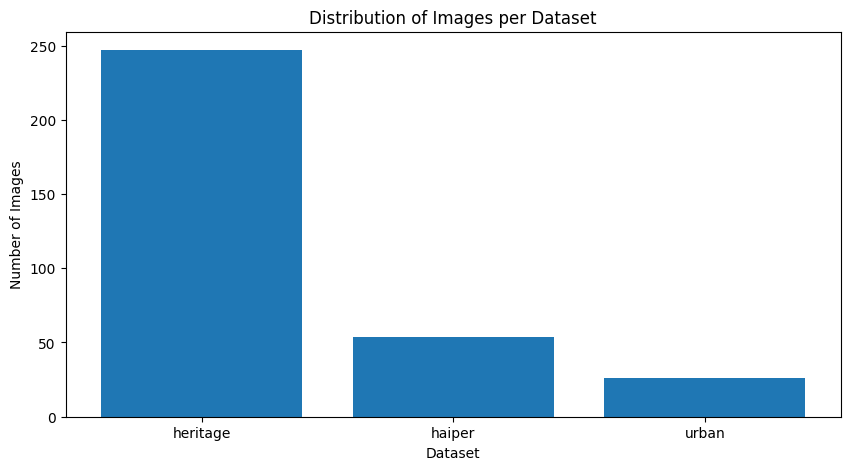

In [6]:
plt.figure(figsize=(10, 5))
plt.bar(dataset_counts.index, dataset_counts.values)
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Dataset')
plt.show()

The distribution of images per dataset shows that the dataset is somewhat imbalanced, with the majority of the images belonging to the "heritage" dataset (247 images), followed by "haiper" (54 images), and lastly "urban" (26 images). This imbalance may affect the model's performance, as it may become biased towards the more dominant dataset (heritage) during training. It is essential to be aware of this imbalance and consider strategies to address it, such as data augmentation, oversampling, or using a different loss function that takes into account class imbalance.

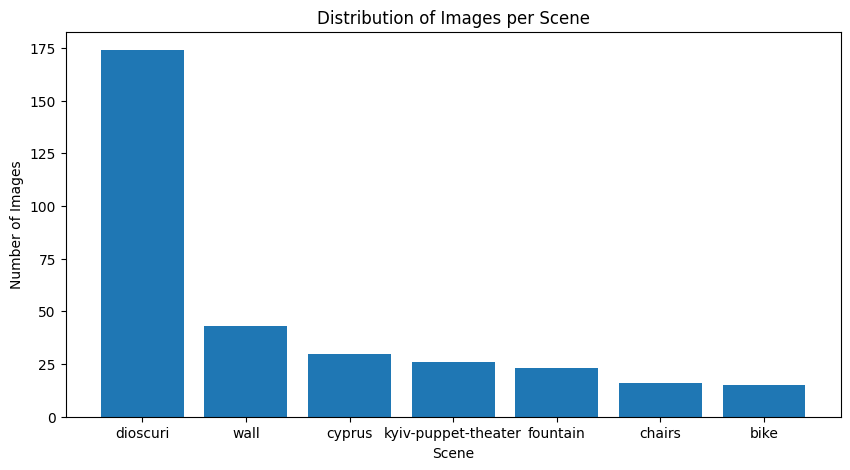

In [7]:
plt.figure(figsize=(10, 5))
plt.bar(scene_counts.index, scene_counts.values)
plt.xlabel('Scene')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Scene')
plt.show()

The distribution of images per scene also shows some imbalance, with the "dioscuri" scene containing the most images (174), followed by "wall" (43), "cyprus" (30), "kyiv-puppet-theater" (26), "fountain" (23), "chairs" (16), and "bike" (15). This distribution indicates that the complexity and the number of images per scene vary significantly. It is important to consider this variation when training the model, as it may be necessary to ensure that the model can handle different complexities and scales of scenes.

## Visualizes the Images

To make sure we know how the data looks like and to understand it even more, we need to visualize the image in our dataset.

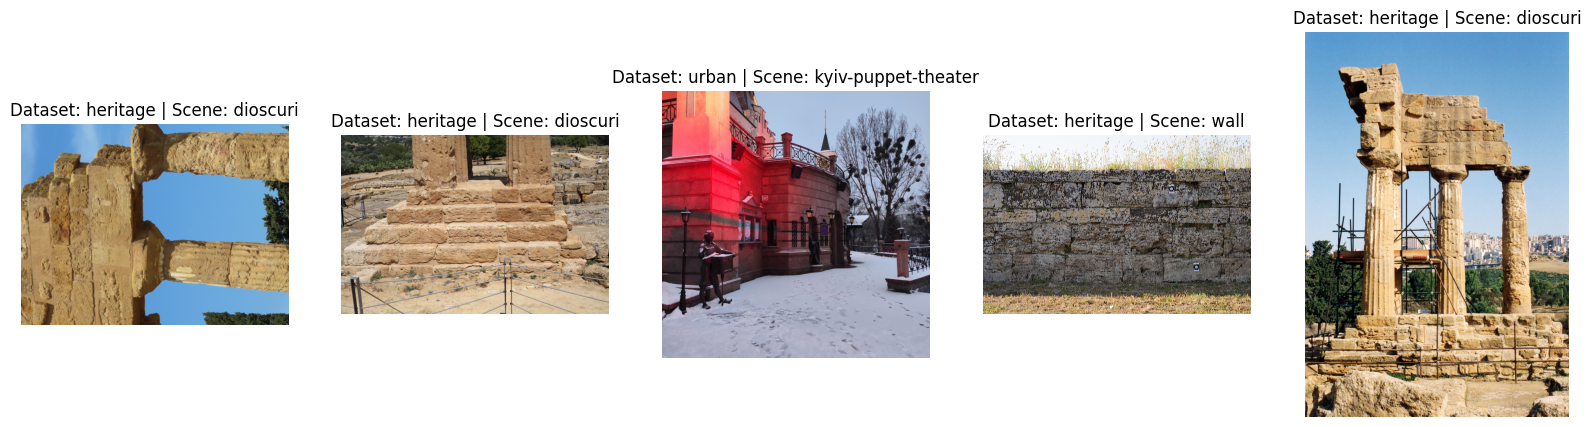

In [8]:
# Visualize images
num_images_to_show = 5
random_image_indices = random.sample(range(len(train_labels)), num_images_to_show)

fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 5))
train_folder = os.path.join(root_dir, 'train')

for i, image_index in enumerate(random_image_indices):
    relative_image_path = train_labels.iloc[image_index]['image_path']
    image_path = os.path.join(train_folder, relative_image_path)
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Dataset: {train_labels.iloc[image_index]['dataset']} | Scene: {train_labels.iloc[image_index]['scene']}")
    axes[i].axis('off')

plt.show()

## Explore 3D Reconstructions

In this step, we explore the 3D reconstructions provided for the training datasets. These reconstructions contain information about the 3D structure of the scene and the camera poses used to create the images. By visualizing these reconstructions, we can gain insights into the spatial arrangement of the cameras, which can help us understand the complexity of the problem and the relationships between the images and their corresponding camera poses.

Due to computational limitations and the speed of processing in the Kaggle notebook, we reduced the number of points and camera poses for visualization purposes. This allows us to have a faster, albeit less detailed, exploration of the 3D reconstructions. Despite this reduction in complexity, the visualizations still provide useful information about the spatial distribution of the cameras and the overall structure of the scenes, which can be helpful in guiding the development of our model.

Detected model format: '.txt'


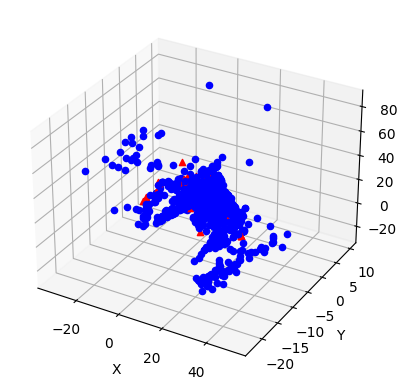

In [9]:
# Explore 3D reconstructions
def plot_sfm_3d_reconstruction(reconstruction, num_points=1000, num_cameras=50):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot 3D points
    point3D_ids = list(reconstruction[2].keys())
    selected_point3D_ids = random.sample(point3D_ids, min(num_points, len(point3D_ids)))

    for point3D_id in selected_point3D_ids:
        point3D = reconstruction[2][point3D_id]
        ax.scatter(point3D.xyz[0], point3D.xyz[1], point3D.xyz[2], c='b', marker='o')

    # Plot camera poses
    image_ids = list(reconstruction[1].keys())
    selected_image_ids = random.sample(image_ids, min(num_cameras, len(image_ids)))

    for image_id in selected_image_ids:
        image = reconstruction[1][image_id]
        camera_center = -image.qvec2rotmat().T @ image.tvec
        ax.scatter(camera_center[0], camera_center[1], camera_center[2], c='r', marker='^')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# You can replace the following path with any other scene's sfm folder path
sample_sfm_folder = os.path.join(train_folder, 'urban/kyiv-puppet-theater/sfm')
cameras, images, points3D = read_write_model.read_model(sample_sfm_folder)
reconstruction = (cameras, images, points3D)
plot_sfm_3d_reconstruction(reconstruction)

## Analyze the distribution of rotation and translation values

Now, what we want to do is, we want to create histograms of the ground truth rotation and translation values to understand their distribution. This can help us identify potential patterns or trends in the camera poses.

In [10]:
# Inspect rotation matrices and translation vectors
def string_to_matrix(matrix_string):
    return np.array(list(map(float, matrix_string.split(';')))).reshape(3, 3)

def string_to_vector(vector_string):
    return np.array(list(map(float, vector_string.split(';'))))

In [11]:
rotation_matrices = train_labels['rotation_matrix'].apply(string_to_matrix)
translation_vectors = train_labels['translation_vector'].apply(string_to_vector)

# Calculate rotation angles (in degrees) for all images
rotation_angles = [np.rad2deg(np.arccos((np.trace(R) - 1) / 2)) for R in rotation_matrices]

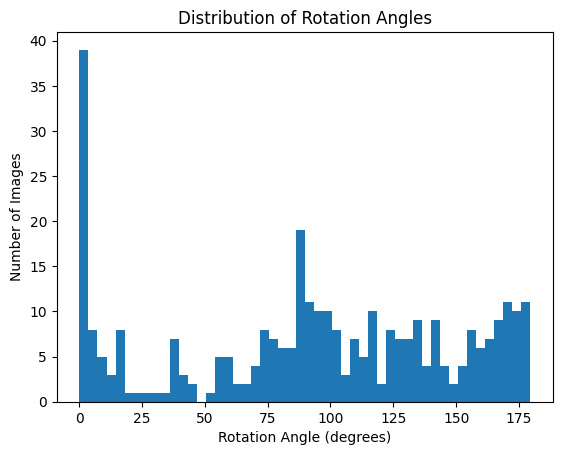

In [12]:
plt.figure()
plt.hist(rotation_angles, bins=50)
plt.xlabel('Rotation Angle (degrees)')
plt.ylabel('Number of Images')
plt.title('Distribution of Rotation Angles')
plt.show()

The distribution of rotation angles and translation distances in the dataset may seem random and somewhat uniform at first glance. The large number of values close to 0 in the first bin suggests that many camera poses have small rotations or translations relative to each other. This could be due to the nature of the images and the way they are captured around the scenes.

However, the seemingly random distribution of the rest of the values is not surprising, given the problem's nature. In the 3D reconstruction task, camera poses are not expected to follow a specific pattern or distribution, as the images can be captured from various angles and distances around the scenes. This randomness reflects the real-world nature of image capture, where photographers may take pictures from a wide range of perspectives and positions.

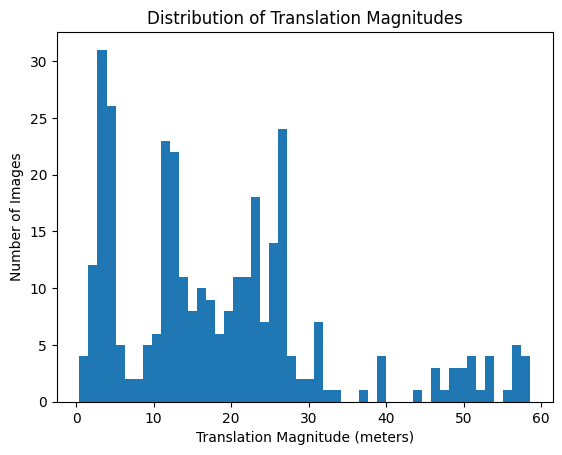

In [13]:
# Calculate the magnitude of the translation vectors for all images
translation_magnitudes = [np.linalg.norm(tvec) for tvec in translation_vectors]

plt.figure()
plt.hist(translation_magnitudes, bins=50)
plt.xlabel('Translation Magnitude (meters)')
plt.ylabel('Number of Images')
plt.title('Distribution of Translation Magnitudes')
plt.show()

In [14]:
# Analyze image resolution and aspect ratio
image_resolutions = [Image.open(os.path.join(train_folder, path)).size for path in train_labels['image_path']]
image_widths, image_heights = zip(*image_resolutions)
aspect_ratios = [w / h for w, h in image_resolutions]

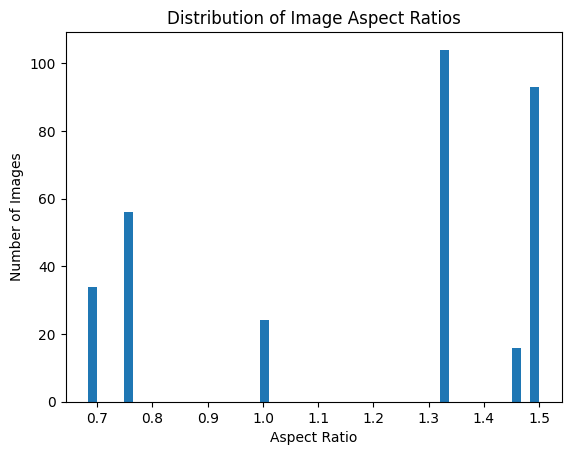

In [15]:
plt.figure()
plt.hist(aspect_ratios, bins=50)
plt.xlabel('Aspect Ratio')
plt.ylabel('Number of Images')
plt.title('Distribution of Image Aspect Ratios')
plt.show()

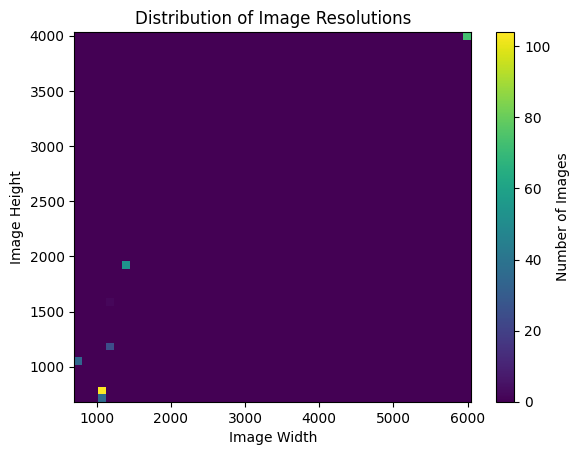

In [16]:
plt.figure()
plt.hist2d(image_widths, image_heights, bins=50)
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title('Distribution of Image Resolutions')
plt.colorbar(label='Number of Images')
plt.show()

## Calculate Relative Pose Errors

Finally, we want to calculate relative pose errors, since it's essential for understanding the impact of translation errors on the model's predictions.

In [17]:
# Calculate relative pose errors
def compute_relative_pose_errors(train_labels):
    pose_errors = []

    for i, row in train_labels.iterrows():
        # Ground truth rotation matrix and translation vector
        gt_rotation_matrix = np.array(row['rotation_matrix'].split(';')).astype(float).reshape(3, 3)
        gt_translation_vector = np.array(row['translation_vector'].split(';')).astype(float)

        # Simulated predicted rotation matrix and translation vector (in practice, you'll use your model's predictions)
        pred_rotation_matrix = gt_rotation_matrix  # Replace with your model's predicted rotation matrix
        pred_translation_vector = gt_translation_vector  # Replace with your model's predicted translation vector

        # Compute relative pose error
        trace_value = np.clip((np.trace(gt_rotation_matrix.T @ pred_rotation_matrix) - 1) / 2, -1, 1)
        rotation_error = np.rad2deg(np.arccos(trace_value))
        translation_error = np.linalg.norm(gt_translation_vector - pred_translation_vector)

        pose_errors.append((rotation_error, translation_error))

    return pose_errors

pose_errors = compute_relative_pose_errors(train_labels)

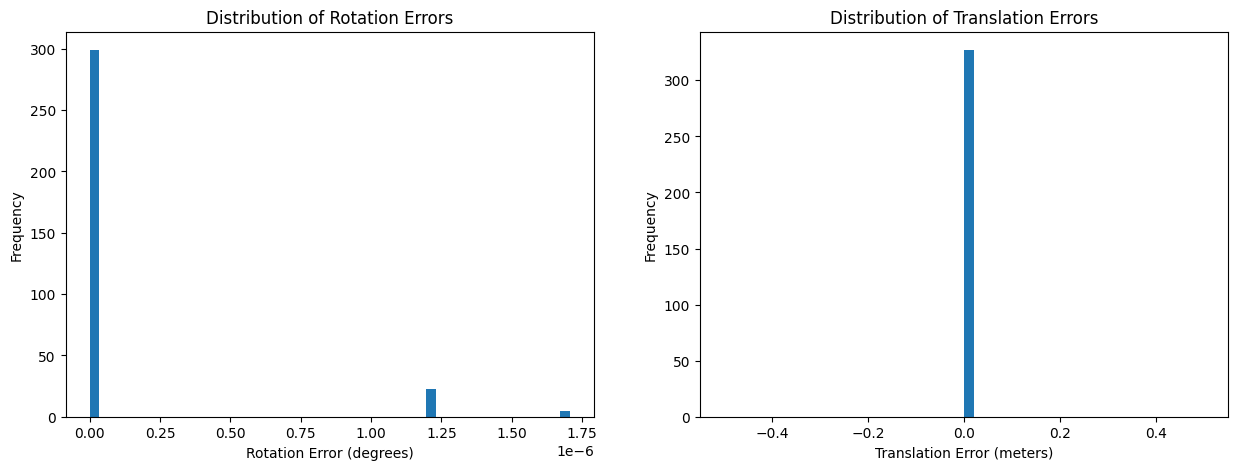

In [18]:
# Visualize the distribution of relative pose errors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

rotation_errors = [error[0] for error in pose_errors]
translation_errors = [error[1] for error in pose_errors]

ax1.hist(rotation_errors, bins=50)
ax1.set_xlabel('Rotation Error (degrees)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Rotation Errors')

ax2.hist(translation_errors, bins=50)
ax2.set_xlabel('Translation Error (meters)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Translation Errors')

plt.show()

From the distribution of Rotation Errors and Translation Errors values, it appears that there are mostly zero errors with a few non-zero values. However, this information alone is not sufficient to draw conclusions. Comparing these errors to the prediction errors and visualizing the distributions will provide more insights into their impact on the model's performance.